In [47]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [48]:
df_activity = pd.read_csv("dailyActivity_merged1.csv")
df_sleep = pd.read_csv("sleepDay_merged.csv")
df_body_metrics = pd.read_csv("weightLogInfo_merged.csv")
# print(df_activity[:1])
# print(df_sleep[:1])
# print(df_body_metrics[:1])

# First, standardize the date format in all dataframes
df_activity['ActivityDate'] = pd.to_datetime(df_activity['ActivityDate'])
df_sleep['SleepDay'] = pd.to_datetime(df_sleep['SleepDay'])
df_body_metrics['Date'] = pd.to_datetime(df_body_metrics['Date'])

# Next, merge the activity and sleep dataframes on the 'Id' and date columns
merged_df = pd.merge(df_activity, df_sleep, 
                     left_on=['Id', 'ActivityDate'], 
                     right_on=['Id', 'SleepDay'], 
                     how='outer')

# Now, merge the resultant dataframe with the body metrics dataframe on the 'Id' and date columns
final_df = pd.merge(merged_df, df_body_metrics, 
                           left_on=['Id', 'ActivityDate'], 
                           right_on=['Id', 'Date'], 
                           how='outer')

# Drop the extra date columns 'SleepDay' and 'Date'
final_df = final_df.drop(columns=['SleepDay', 'Date'])
print(final_df.head())
# print(final_merged_df[:1])

# Count total rows in the dataframe
# print(len(final_merged_df))

# Check for null values
# print(final_merged_df.isnull().sum())

# Drop rows with null values
# final_merged_df = final_merged_df.dropna()
# print(len(final_merged_df))
# looks like every row has at least 1 null, shoot

# Fill null values with the mean of the column
# final_df.fillna(final_df.mean(), inplace=True)

final_df['TotalSteps'].mean()
# 7652.188759278897

final_df = final_df.drop(columns=['Id', 'ActivityDate', 'TrackerDistance','SedentaryActiveDistance', 'LoggedActivitiesDistance', 'LoggedActivitiesDistance', 'WeightKg', 'WeightPounds', 'BMI', 'Fat', 'IsManualReport', 'LogId'])
# 'VeryActiveDistance', 'ModeratelyActiveDistance', 'LightActiveDistance'
final_df['SleepEfficiency'] = final_df['TotalMinutesAsleep'] / final_df['TotalTimeInBed'] * 100
final_df = final_df.dropna(subset=['SleepEfficiency'])
final_df = final_df.dropna(subset=['TotalMinutesAsleep'])

final_df.to_csv('final_dataset.csv', index=False)

           Id ActivityDate  TotalSteps  TotalDistance  TrackerDistance  \
0  1503960366   2016-04-12     13162.0           8.50             8.50   
1  1503960366   2016-04-13     10735.0           6.97             6.97   
2  1503960366   2016-04-14     10460.0           6.74             6.74   
3  1503960366   2016-04-15      9762.0           6.28             6.28   
4  1503960366   2016-04-16     12669.0           8.16             8.16   

   LoggedActivitiesDistance  VeryActiveDistance  ModeratelyActiveDistance  \
0                       0.0                1.88                      0.55   
1                       0.0                1.57                      0.69   
2                       0.0                2.44                      0.40   
3                       0.0                2.14                      1.26   
4                       0.0                2.71                      0.41   

   LightActiveDistance  SedentaryActiveDistance  ...  Calories  \
0                 6.06    

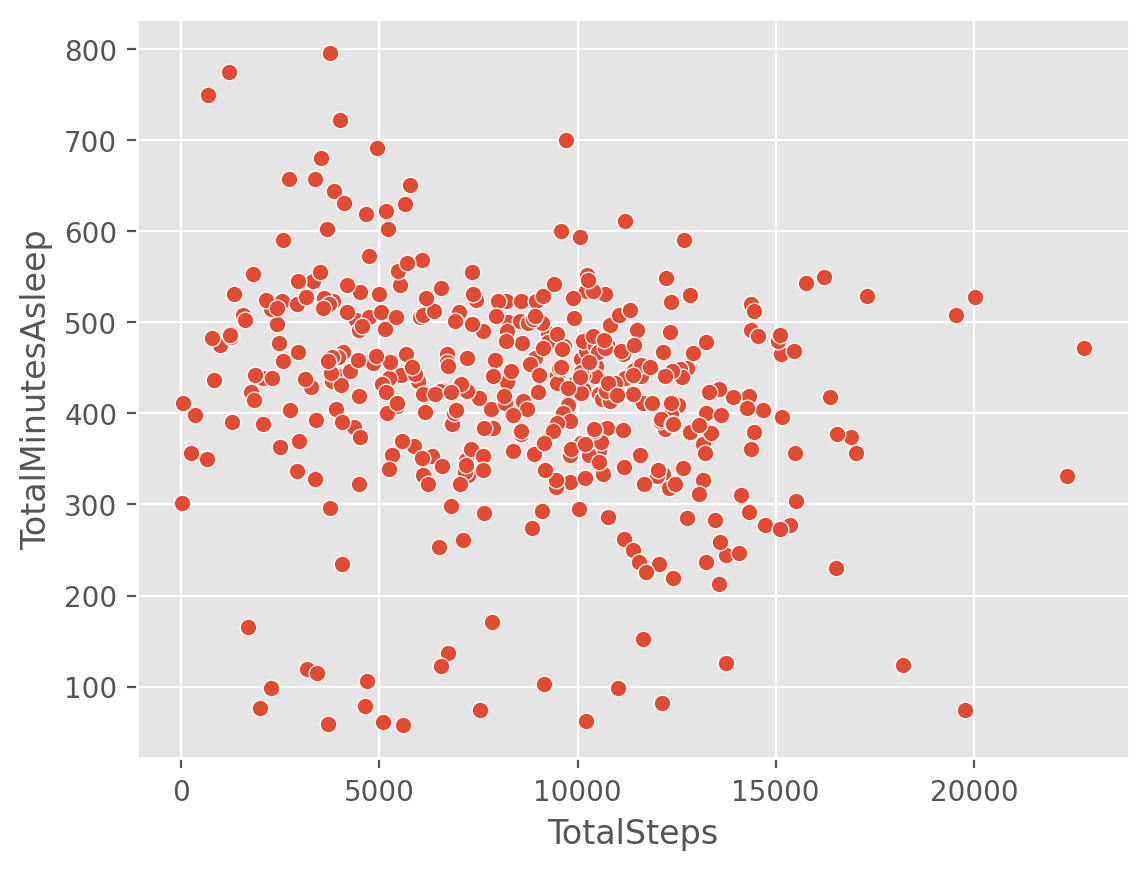

In [49]:
# initial data exploration
# plt.plot(final_df['TotalSteps'], final_df['TotalMinutesAsleep'], 'o', alpha=0.5)
# plt.xlabel('Total Steps')
# plt.ylabel('Total Minutes Asleep')
# plt.title('Total Steps vs Total Minutes Asleep')
# plt.show()

# only use rows with no null values for very active distance and total minutes asleep
# plot_df = final_df.dropna(subset=['VeryActiveDistance', 'TotalMinutesAsleep'])
# plt.plot(plot_df['VeryActiveDistance'], plot_df['TotalMinutesAsleep'], 'o', alpha=0.5)
# plt.xlabel('Very Active Distance')
# plt.ylabel('Total Minutes Asleep')
# plt.title('Very Active Distance vs Total Minutes Asleep')

# final_df.plot(x='ActivityDate', y='TotalSteps')

# Scatter plot of TotalSteps vs TotalMinutesAsleep
sns.scatterplot(data=final_df, x='TotalSteps', y='TotalMinutesAsleep')
plt.show()

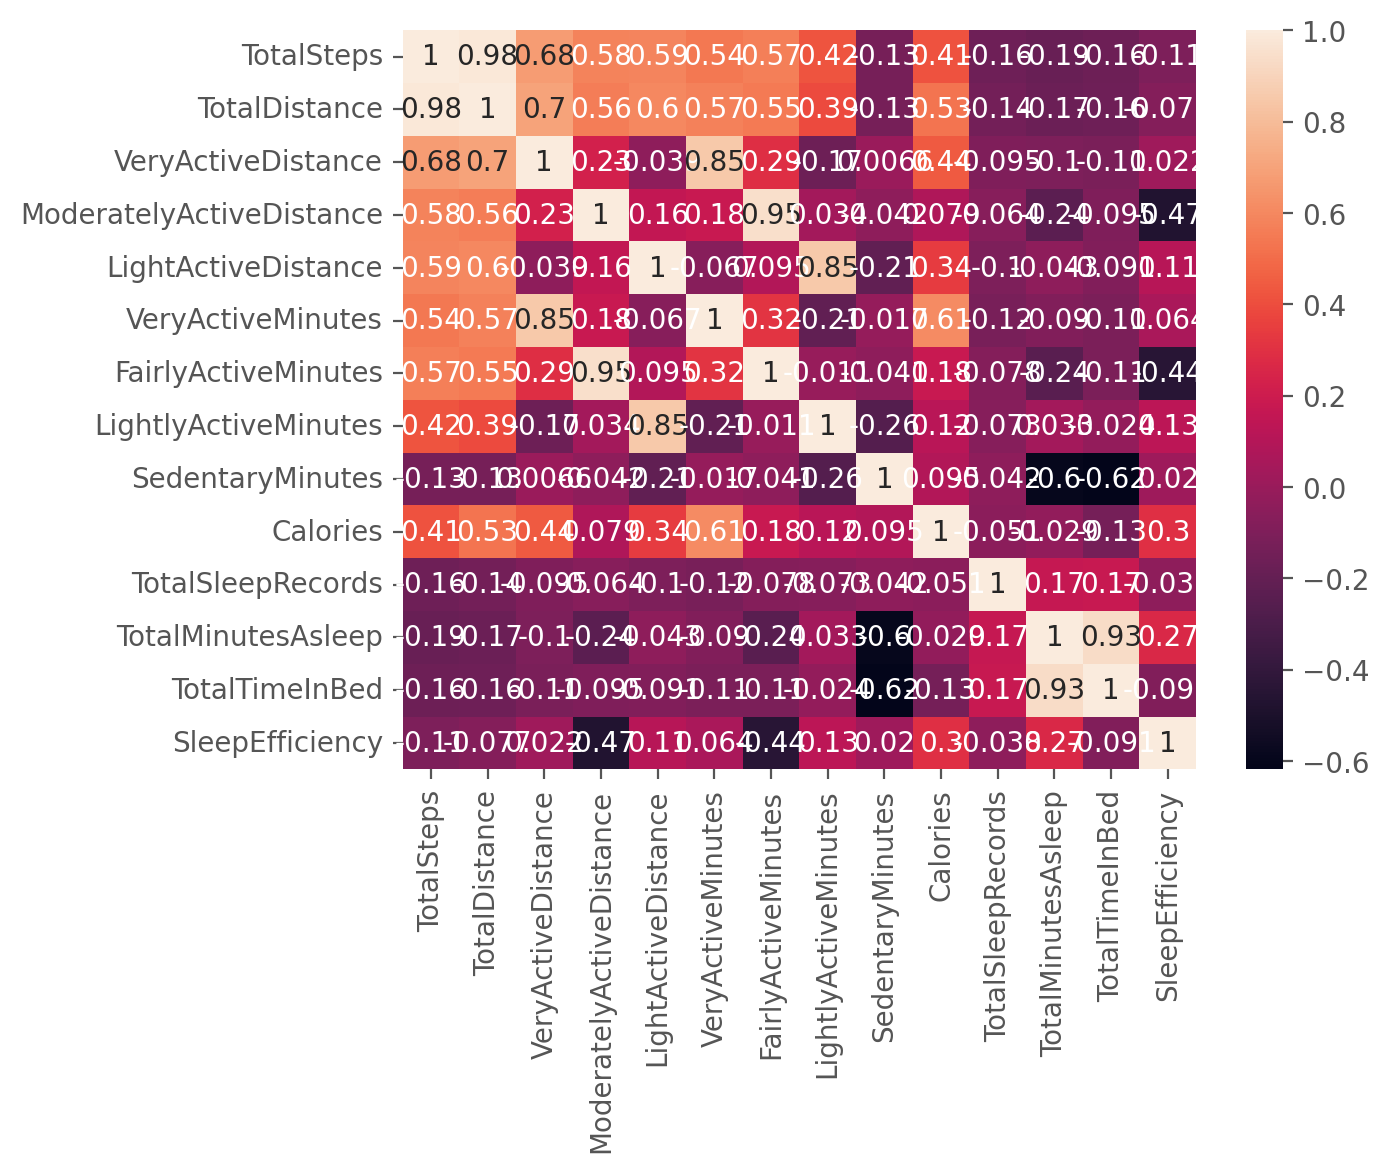

In [50]:
# Correlation matrix to see relationships between features
correlation_matrix = final_df.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

C:\Users\boon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


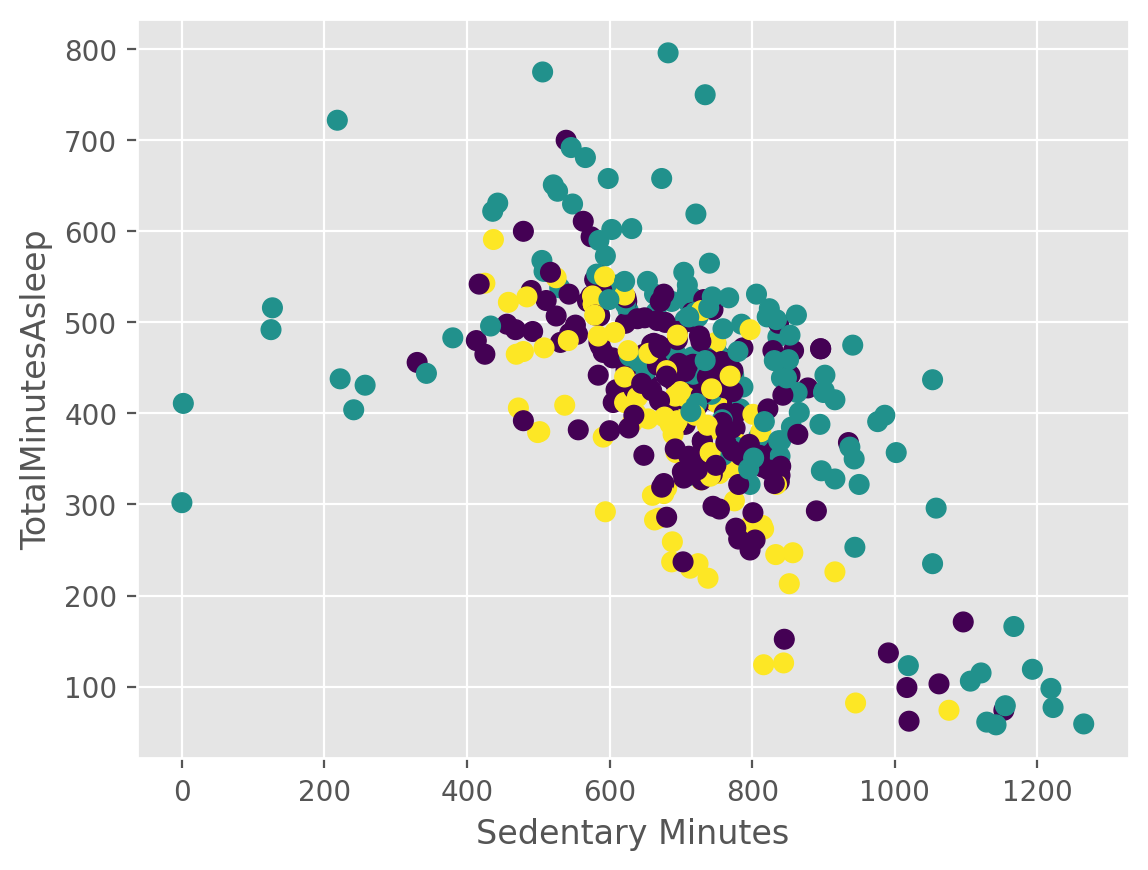

In [58]:
# use kmeans clustering to see if there are any natural clusters in the data
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(final_df)
# float() argument must be a string or a real number, not 'Timestamp'

y_kmeans = kmeans.predict(final_df)

plt.xlabel('Sedentary Minutes')
plt.ylabel('TotalMinutesAsleep')
plt.scatter(final_df['SedentaryMinutes'], final_df['TotalMinutesAsleep'], c=y_kmeans, s=50, cmap='viridis')


Original shape: (413, 14)
Reduced shape: (413, 2)


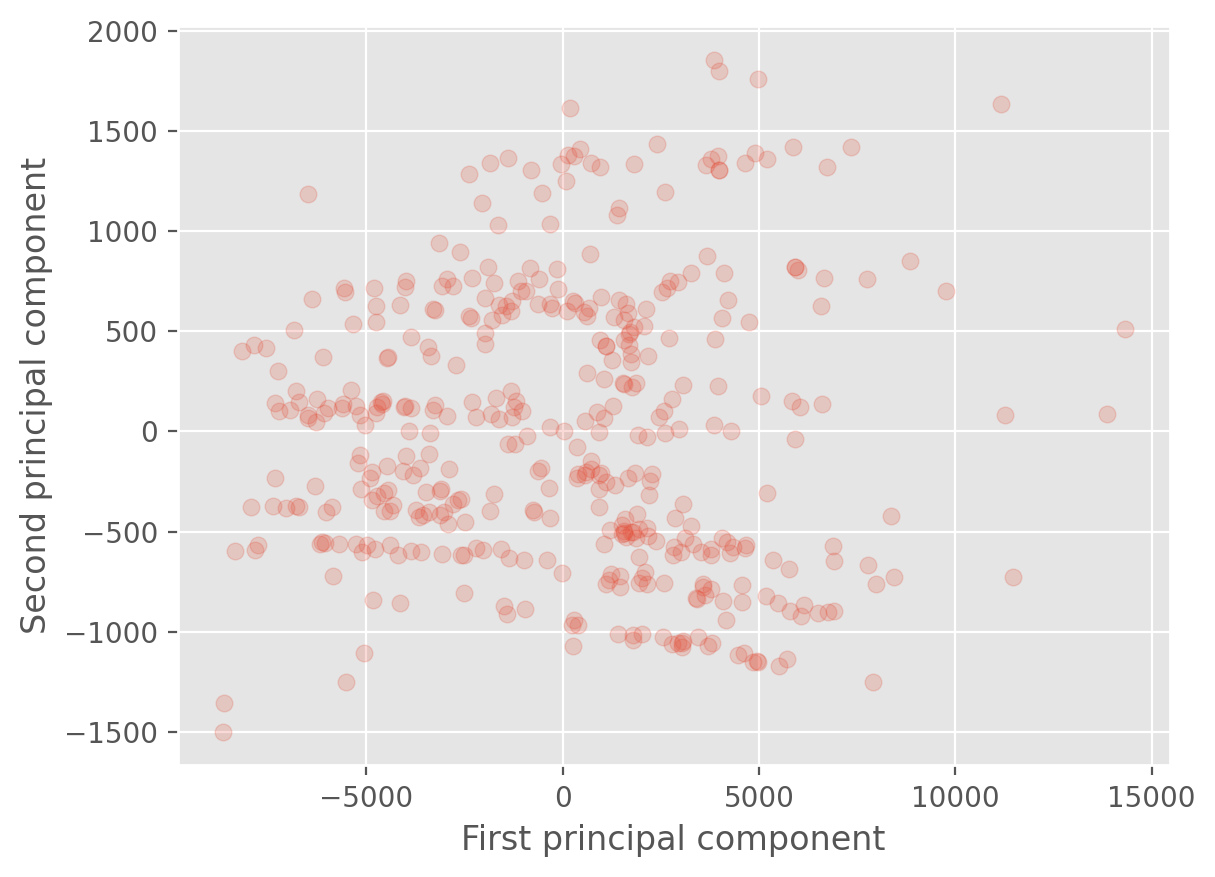

In [62]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(final_df)
X_pca = pca.transform(final_df)
print("Original shape: {}".format(str(final_df.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))

plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.2)